In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [20]:
DF_cleaned=pd.read_csv('DF_nettoyé.csv')

In [21]:
col_num=[]
col_obj=[]
for col in DF_cleaned.columns:
    if DF_cleaned[col].dtype in ['int64','float64']:
        col_num.append(col)
    else:
        col_obj.append(col)

In [22]:
for col in ['LargestPropertyUseTypeGFA','SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseTypeGFA',
            'ENERGYSTARScore']:
    del(col_num[col_num.index(col)])

# 2) 'TotalGHGEmissions'

### DUMMY

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error,r2_score

X=DF_cleaned[col_num].drop(['TotalGHGEmissions'],axis=1)
y=DF_cleaned['TotalGHGEmissions']

# Séparation train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Créer un Dummy Regressor qui prédit la moyenne
dummy_reg = DummyRegressor(strategy="mean")

# Entraîner le modèle
dummy_reg.fit(X_train, y_train)

# Prédictions sur l'ensemble de test
y_pred = dummy_reg.predict(X_test)

# Calculer l'erreur quadratique moyenne (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculer la racine de l'erreur quadratique moyenne (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

# Calculer le coefficient de détermination R²
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2}")


Mean Squared Error: 481103.8222514026
Root Mean Squared Error: 693.6164806659388
R² Score: -8.136069568376314e-05


### REGRESSION LINEAIRE

In [24]:
from sklearn.linear_model import LinearRegression

# Créer et entraîner un modèle de régression linéaire
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

# Prédictions
y_pred_linear = linear_reg.predict(X_test)

# Évaluation
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

print(f"Linear Regression MSE: {mse_linear}")
print(f"Linear Regression R² Score: {r2_linear}")


Linear Regression MSE: 9.583910287102984e-06
Linear Regression R² Score: 0.9999999999800777


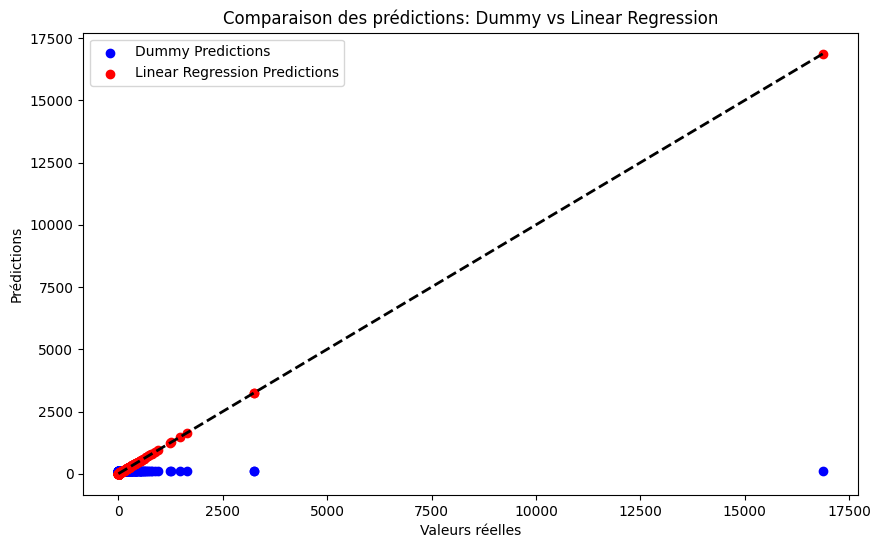

In [25]:


plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Dummy Predictions')
plt.scatter(y_test, y_pred_linear, color='red', label='Linear Regression Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Valeurs réelles')
plt.ylabel('Prédictions')
plt.title('Comparaison des prédictions: Dummy vs Linear Regression')
plt.legend()
plt.show()

In [26]:
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.inspection import permutation_importance
# Diviser les données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardiser les features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Ajuster le modèle
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# 1. Coefficients standardisés
coef_std = pd.DataFrame({'feature': X.columns, 'coef_std': model.coef_})
coef_std = coef_std.sort_values('coef_std', key=abs, ascending=False)
print("1. Coefficients standardisés:")
print(coef_std)
print()

# 2. Valeurs p
X_train_sm = sm.add_constant(X_train)
model_sm = sm.OLS(y_train, X_train_sm).fit()
p_values = pd.DataFrame({'feature': X.columns, 'p_value': model_sm.pvalues[1:]})
p_values = p_values.sort_values('p_value')
print("2. Valeurs p:")
print(p_values)
print()

# 3. R² partiel
r2_partial = []
for feature in X.columns:
    X_reduced = X_train.drop(feature, axis=1)
    model_reduced = LinearRegression().fit(X_reduced, y_train)
    r2_reduced = model_reduced.score(X_reduced, y_train)
    r2_full = model.score(X_train, y_train)
    r2_partial.append((r2_full - r2_reduced) / (1 - r2_reduced))

r2_partial = pd.DataFrame({'feature': X.columns, 'r2_partial': r2_partial})
r2_partial = r2_partial.sort_values('r2_partial', ascending=False)
print("3. R² partiel:")
print(r2_partial)
print()

# 4. Feature importance basée sur la permutation
perm_importance = permutation_importance(model, X_test_scaled, y_test, n_repeats=10, random_state=42)
perm_importance_df = pd.DataFrame({'feature': X.columns, 'importance': perm_importance.importances_mean})
perm_importance_df = perm_importance_df.sort_values('importance', ascending=False)
print("4. Feature importance basée sur la permutation:")
print(perm_importance_df)

1. Coefficients standardisés:
                      feature      coef_std
32                 %_immeuble  2.247629e+10
31                  %_parking  2.247629e+10
23          somme_conso(kBtu) -2.569955e+09
8            PropertyGFATotal  2.392192e+09
10     PropertyGFABuilding(s) -2.289594e+09
19          Electricity(kBtu)  1.832332e+09
16      SiteEnergyUseWN(kBtu)  1.187625e+09
24        conso*surface(kBtu) -1.163974e+09
21           NaturalGas(kBtu)  5.215391e+08
17             SteamUse(kBtu)  5.039982e+08
9          PropertyGFAParking -3.244307e+08
15        SiteEnergyUse(kBtu)  2.653663e+08
27  dif_energie_surface(kBtu)  2.063307e+08
5                   YearBuilt  2.039655e+08
25                        AGE  2.039655e+08
26            dif_conso(kBtu) -3.149684e+07
20         NaturalGas(therms)  2.332042e+03
18           Electricity(kWh) -1.024350e+03
28               %_elec(kBtu)  5.201844e-03
29                %_gas(kBtu)  4.963221e-03
14       SourceEUIWN(kBtu/sf) -4.553175e-03
13

c:\Users\lenovo\Desktop\OpenClassrooms\PROJET_OC\PROJET_4\environnement_virtuel_projet_4\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\lenovo\Desktop\OpenClassrooms\PROJET_OC\PROJET_4\environnement_virtuel_projet_4\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\lenovo\Desktop\OpenClassrooms\PROJET_OC\PROJET_4\environnement_virtuel_projet_4\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\lenovo\Desktop\OpenClassrooms\PROJET_OC\PROJET_4\environnement_virtuel_projet_4\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\lenovo\Desktop\OpenClassrooms\PROJET_OC\PROJET_4\environnem

3. R² partiel:
                      feature    r2_partial
1                     ZipCode -3.330663e+37
4                   Longitude -3.330964e+37
7              NumberofFloors -3.332414e+37
14       SourceEUIWN(kBtu/sf) -3.332771e+37
13         SourceEUI(kBtu/sf) -3.332983e+37
3                    Latitude -3.333117e+37
20         NaturalGas(therms) -3.333117e+37
12         SiteEUIWN(kBtu/sf) -3.333519e+37
2         CouncilDistrictCode -3.333743e+37
11           SiteEUI(kBtu/sf) -3.333799e+37
18           Electricity(kWh) -3.334357e+37
22      GHGEmissionsIntensity -3.334357e+37
28               %_elec(kBtu) -3.334402e+37
30              %_steam(kBtu) -3.334402e+37
29                %_gas(kBtu) -3.334413e+37
6           NumberofBuildings -3.334413e+37
0               OSEBuildingID -3.334424e+37
23          somme_conso(kBtu) -3.334503e+37
27  dif_energie_surface(kBtu) -3.334503e+37
26            dif_conso(kBtu) -3.334503e+37
25                        AGE -3.334503e+37
31               